Importo librerias necesarias.

In [132]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import norm

Función para calcular el precio de una Call europea vainilla, usando un árbol trinomial.

In [133]:
def Call_Eu_Trinomial(Spot, Strike, T, r, v, n):
    alpha = r - (0.5 * v * v)
    K = T / n
    h = v * math.sqrt(3.0 * K)
    pu = (v * v * K / h / h + alpha * alpha * K * K / h / h + alpha * K / h) / 2.0
    pd = (v * v * K / h / h + alpha * alpha * K * K / h / h - alpha * K / h) / 2.0
    pm = 1.0 - pu - pd

    exp_rT = math.exp(-r * T / n)

    A = np.zeros((2 * n + 1, n+1))
    A[n,0] = Spot

    u = math.exp(h)
    d = 1/u

    #Árbol con los precios por cada tiempo
    for j in range(1, n+1):
        for i in range(n-j, n+j+1):
            cota = n
            if cota > i:
                A[i,j] = A[i+1,j-1] * u
            elif cota < i:
                A[i,j] = A[i-1,j-1] * d
            else:
                A[i,j] = A[i,j-1]

    #Op tendra el valor de la opcion en cada nodo del arbol de precios S
    Op = np.zeros((2*n+1,n+1))

    for i in range(2 * n + 1):
        Op[i,n] = max(A[i,n] - Strike, 0)

    for i in range(1, 2 * n):
        Op[i,n - 1] = exp_rT * (pu * Op[i-1, n] + pm * Op[i,n] + pd * Op[i+1, n])

    for j in range(n-2, -1, -1):
        for i in range(n-j, n+j+1):
            Op[i,j] = exp_rT * (pu * Op[i-1, j+1] + pm * Op[i, j+1] + pd * Op[i+1, j+1])
    return Op[n,0]

Spot = 100  # Precio Spot
Strike = 130  # Precio Strike
T = 3  # Años para maduración
r = 0.05 # Tasa libre de riesgo
v = 0.2  # Volatilidad
n = 700 # Numero de pasos temporales

c = Call_Eu_Trinomial(Spot, Strike, T, r, v, n)
print(c)

9.376111804036409


Armamos una lista con el error cuadratico de aproximar el precio de una call con el modelo trinomial comparado con el precio obtenido de forma analitica con Black Scholes.

In [134]:
Black_Scholes_Price = 9.373804025
Error = [(Black_Scholes_Price - Call_Eu_Trinomial(Spot, Strike, T, r, v, i))**2 for i in range(1, 701)]

Graficamos el error.

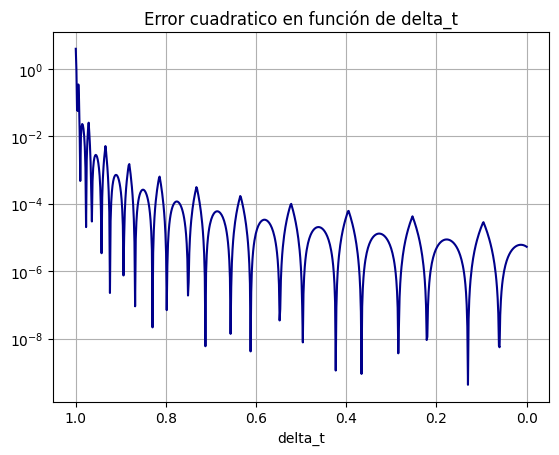

In [135]:
fig, ax = plt.subplots(1,1)
x = np.linspace(1,0,700)
ax.plot(x, Error, color='darkblue')
ax.invert_xaxis()
ax.grid()
plt.yscale("log")
plt.xlabel('delta_t')
plt.title('Error cuadratico en función de delta_t')
plt.show()

Función para calcular el precio de una Call Barrera Up and Out.

In [136]:
def Call_Barrier_IandO(Spot, Strike, Barrier, T, r, v, n):
    alpha = r - (0.5 * v * v)
    K = T / n
    h = v * math.sqrt(3.0 * K)
    pu = (v * v * K / h / h + alpha * alpha * K * K / h / h + alpha * K / h) / 2.0
    pd = (v * v * K / h / h + alpha * alpha * K * K / h / h - alpha * K / h) / 2.0
    pm = 1.0 - pu - pd

    exp_rT = math.exp(-r * T / n)

    A = np.zeros((2 * n + 1, n+1))
    A[n,0] = Spot

    u = math.exp(h)
    N = round(math.log(Barrier/Spot)/math.log(u))
    u = math.exp(math.log(Barrier/Spot)/N)
    d = 1/u

    #Arbol con los precios por cada tiempo
    for j in range(1, n+1):
        for i in range(n-j, n+j+1):
            cota = n
            if cota > i:
                A[i,j] = A[i+1,j-1] * u
            elif cota < i:
                A[i,j] = A[i-1,j-1] * d
            else:
                A[i,j] = A[i,j-1]

    #Op tendra el valor de la opcion en cada nodo del arbol de precios S
    Op = np.zeros((2*n+1,n+1))

    Loc = 0
    for i in range(2 * n + 1):
        #Aca tengo cuidado con resta de numeros float en python, no siempre da 0 por ende no simpre el payoff en la 
        # rama donde esta el precio de la barrera será 0
        distancia = np.abs(A[i,n]-Barrier)
        if distancia < 1e-10: 
            Loc = i
            Op[i,n] = 0
        else:
            if A[i,n] >= Barrier : Op[i,n] = 0
            else : Op[i,n] = max(A[i,n] - Strike, 0)

    for i in range(1, 2 * n):
        if  i == Loc: Op[i,n - 1] = 0
        else:
            Op[i,n - 1] = exp_rT * (pu * Op[i-1, n] + pm * Op[i,n] + pd * Op[i+1, n])

    for j in range(n-2, -1, -1):
        for i in range(n-j, n+j+1):
            if i == Loc: Op[i,j] = 0
            else:
                Op[i,j] = exp_rT * (pu * Op[i-1, j+1] + pm * Op[i, j+1] + pd * Op[i+1, j+1])

    return Op[n,0]

Spot = 100  # Precio Spot
Strike = 130  # Precio Strike
T = 3  # Años para maduración
r = 0.05 # Tasa libre de riesgo
v = 0.2  # Volatilidad
n = 700 # Numero de pasos temporales
Barrier = 500 #Precio barrera. (Que no sea próximo a el precio spot, caso contrario dará error)

print("The AMM price is ", Call_Barrier_IandO(Spot, Strike, Barrier, T, r, v, n))

The AMM price is  9.362725391943817


Funciones auxiliares para comparar los resultados del algoritmo dado con los de la fórmula cerrada dada en el Hull sección 24.6.

In [137]:
def lam(r, var):
    return (r + var**2 / 2) /var /var

def y(Barrier, S0, Strike, var, T, lam):
    return math.log(Barrier**2 / S0 / Strike) / var / math.sqrt(T) + lam * var * math.sqrt(T)

def x1(S0, Barrier, T, var, lam):
    return math.log(S0/Barrier) / var / math.sqrt(T) + lam * var * math.sqrt(T)

def y1(S0, Barrier, T, var, lam):
    return math.log(Barrier/S0) / var / math.sqrt(T) + lam * var * math.sqrt(T)

def c_up_in(x1,y1,y,S0,Strike,r,T,var,Barrier,lam):
    return (S0*norm.cdf(x1) - Strike*math.exp(-r*T)*norm.cdf(x1-var*math.sqrt(T)) - S0*(Barrier/S0)**(2*lam)*(norm.cdf(-y) - norm.cdf(-y1))
            + Strike*math.exp(-r*T)*(Barrier/S0)**(2*lam-2)*(norm.cdf(-y+var*math.sqrt(T)) - norm.cdf(-y1+var*math.sqrt(T))))

def c_up_out(c, c_in):
    return c - c_in

l = lam(r,v)
Y = y(Barrier,Spot,Strike,v,T,l)
X1 = x1(Spot,Barrier,T,v,l)
Y1 = y1(Spot,Barrier,T,v,l)
cUpIn = c_up_in(X1,Y1,Y,Spot,Strike,r,T,v,Barrier,l)
print(c_up_out(c,cUpIn))

9.372564681123393


Ahora compararemos el precio de la opción barrera generada por el algoritmo implementado y el precio de la misma opción barrera con la fórmula cerrada dada en el libro de Hull en la seccion 24.6 para distintas barreras H tales que H >> Strike.

In [138]:
Barriers = [200 + 50*i for i in range(25)]
Errores = [np.abs(c_up_out(c, c_up_in(X1,Y1,Y,Spot,Strike,r,T,v,Bs,l)) - Call_Barrier_IandO(Spot, Strike, Bs, T, r, v, n)) for Bs in Barriers]

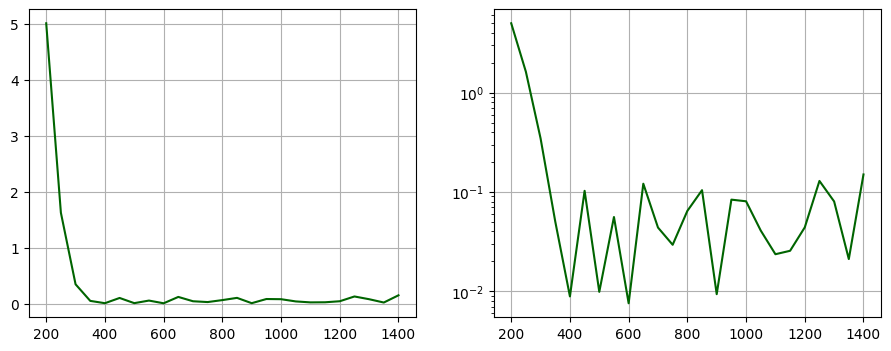

In [139]:
fig, ax = plt.subplots(1,2, figsize=(11,4))
x = np.linspace(200,1400,25)
ax[0].plot(x, Errores, color='darkgreen')
ax[1].plot(x, Errores, color='darkgreen')
ax[0].grid()
ax[1].grid()
plt.yscale("log")
plt.show()